In [1]:
using TSSM
using PyPlot
include("time_stepper.jl");

 *** OPENMP n_threads =           8


## Linear Schrödinger equation with time dependent potential

The *linear* Schrödinger equation
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=\epsilon\Delta\psi(x,t)+\epsilon^{-1}V(x,t)\psi(x,t),
\quad \psi(x,0) = u_0(x)$$
with time dependent potential

We use a Fourier spectral method on the computational domain  $[x_\mathrm{min},x_\mathrm{max}]=[-1,1]$ with $n_x=2048$ discretization points:

In [27]:
nx = 2048
xmin = -1.0
xmax = +1.0

const x0=-0.3
const k0=0.1
const delta=1.22*10.0^(-4)
const eps=2.0^(-11)#1.0
roh(x) = exp(-1./(1-x.^2)).*(abs(x).<1.0)
u0(x) = (delta*pi)^(-1/4)*exp(1im*k0*(x-x0)/delta-(x-x0).^2/(2*delta))
V0(x) = roh(4*x).*sin(20*pi*x)
VE(x,t)=V0(x)+roh(3*t-1)*roh(sin(2*pi*(x-t)))

VE (generic function with 1 method)

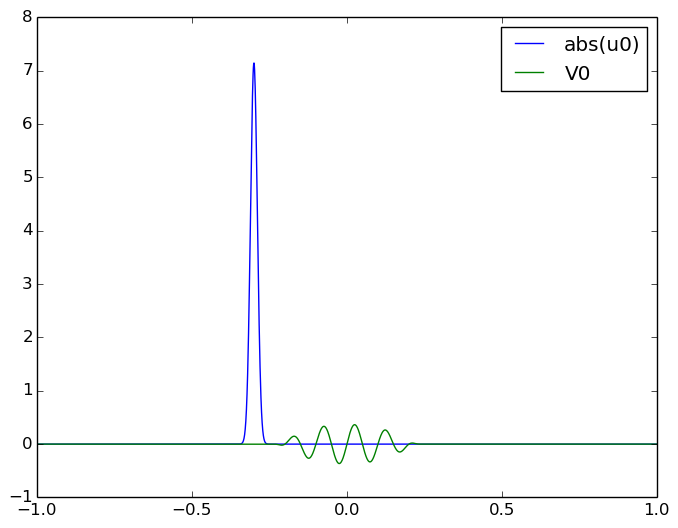

PyObject <matplotlib.legend.Legend object at 0x7f944fdc1510>

In [28]:
figure(2)
hold(false)
x=(collect(1:nx)/nx)*2-1.0
plot(x,abs(u0(x)),label="abs(u0)")
hold(true)
plot(x,V0(x),label="V0")
legend()

In [29]:
#some schemes
#Emb 4/3 AK p
embedded_scheme_43 = EmbeddedScheme(
          ( 0.125962888700250514,  0.333588446797901933,
            0.751193431379145450, -0.338296598434303506,
            0.127551831557005609,  0.127551831557005609,
           -0.338296598434303506,  0.751193431379145450,
            0.333588446797901933,  0.125962888700250514 ),

          ( 0.125962888700250514,  0.333588446797901933,
            0.751193431379145450, -0.338296598434303506,
            0.0                 ,  0.261153550449697153,
           -0.242703571757396124,  0.596114052266110425,
            0.365547251678000160,  0.147440548920593995 ),

            4 )
#PP 3/4 A
palindromic_scheme_34 = PalindromicScheme( 
          ( 0.268330095781759925,  0.919661523017399857, 
           -0.187991618799159782, -0.187991618799159782, 
            0.919661523017399857,  0.268330095781759925 ),
            3 )
#PP 5/6 A
palindromic_scheme_56 = PalindromicScheme(
          ( 0.201651044312324230,   0.578800656272664932, 
            0.562615975356569200,   0.273128836056524479, 
            0.253874038247554845,  -0.102733803148432142, 
           -0.835351693190370636,   0.068014946093165092, 
            0.068014946093165092,  -0.835351693190370636,
           -0.102733803148432142,   0.253874038247554845, 
            0.273128836056524479,   0.562615975356569200, 
            0.578800656272664932,   0.201651044312324230 ),            
            5 )
#defectbased
embedded_scheme_43_D = DefectBasedScheme(
            embedded_scheme_43.scheme2,
            embedded_scheme_43.order )
palindromic_scheme_34_D = DefectBasedScheme( 
            palindromic_scheme_34.scheme,
            palindromic_scheme_34.order )
palindromic_scheme_56_D = DefectBasedScheme(
            palindromic_scheme_56.scheme,            
            palindromic_scheme_56.order )
schemes=[embedded_scheme_43  ,palindromic_scheme_34  ,palindromic_scheme_56,
         embedded_scheme_43_D,palindromic_scheme_34_D,palindromic_scheme_56_D];

  1.301770 seconds (19.70 k allocations: 593.297 MB, 3.07% gc time)
  

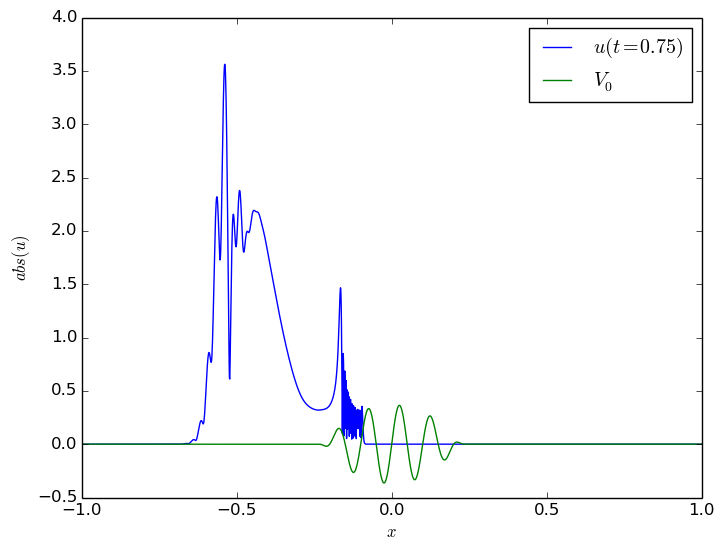

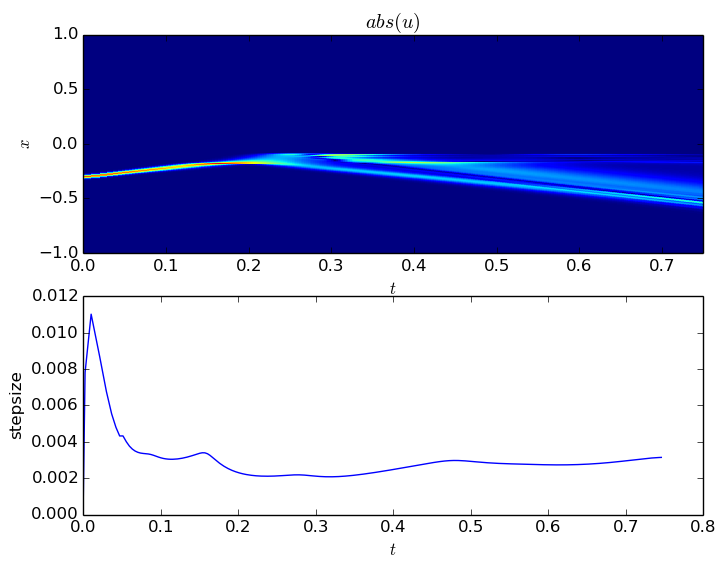

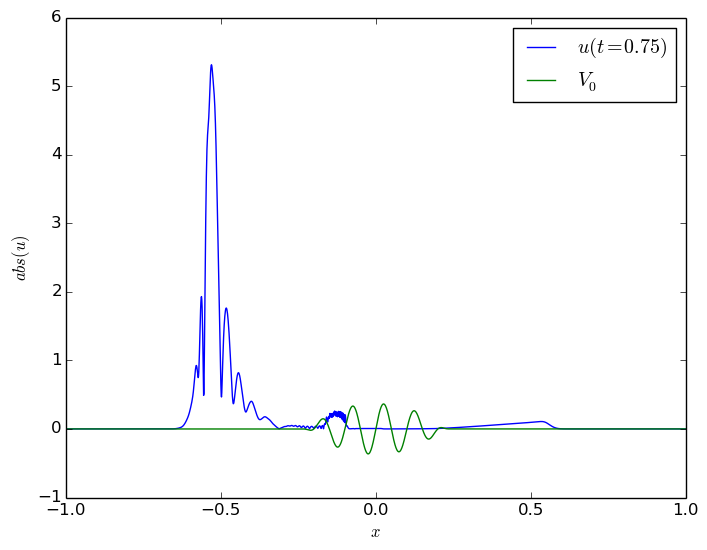

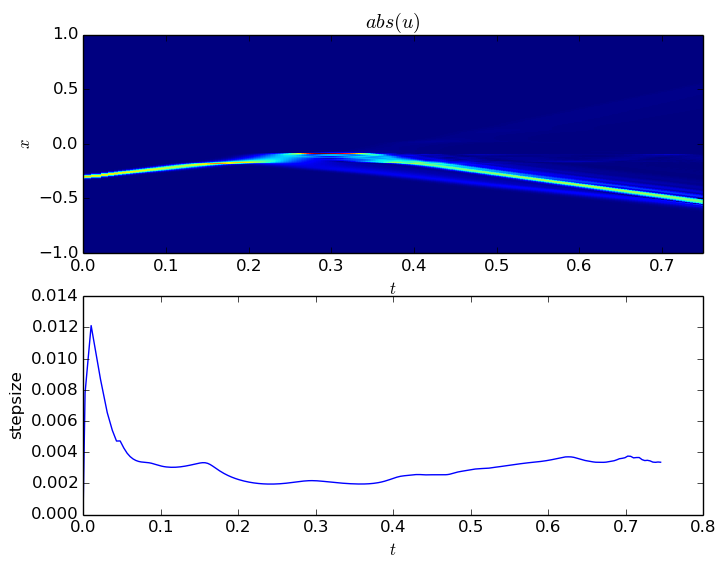

2.689501 seconds (19.30 k allocations: 571.962 MB, 1.37% gc time)


In [37]:
method1 = Schroedinger1D(nx, xmin, xmax, potential=V0, hbar=eps, mass=0.5)
method2 = Schroedinger1D(nx, xmin, xmax, potential_t=VE,hbar=eps, mass=0.5)
methodes=[method1,method2]
me=0
for method in methodes
psi = wave_function(method)
set!(psi, u0)  # initial data

x = get_nodes(method);
to_real_space!(psi);
u = get_data(psi, true);

tend=0.75
t0=0.0
out=1
tol=1e-8

plotdata=abs(u)
steps=[0.0]
mytime=[0.0]
told=0.0
nsteps=0

    @time  for t in adaptive_time_stepper(psi, t0, tend, eps, tol, palindromic_scheme_56, "AB")
     #@printf("t=%20.18E \n",t)
      push!(steps,t-told)
      push!(mytime,t)
      told=t
      nsteps=nsteps+1
      if out==1
      to_real_space!(psi)
      plotdata = [plotdata abs(u)]
      end
  end

    figure(1+me)
  hold(false)
  to_real_space!(psi)
  u = get_data(psi, true);
  plot(x,abs(u),label="\$u(t=0.75)\$")
hold(true)
plot(x,V0(x),label="\$V_0\$")
      xlabel("\$x\$")
    ylabel("\$abs(u)\$")
    legend()

    figure(2+me)
  hold(false)
  if out==1
  subplot(2, 1, 1)
  pcolormesh(mytime,x,plotdata)
  xlabel("\$t\$")
  ylabel("\$x\$")
  #colorbar()
  axis([t0,tend,xmin,xmax])
  title("\$abs(u)\$")

  subplot(2, 1, 2)
    #figure(3+me)
  end

  plot(mytime[1:end-2], steps[2:end-1])
  xlabel("\$t\$")
  ylabel("stepsize")
  savefig("step.png", bbox_inches="tight")
  me=me+3
end

In [31]:
nsteps

.887288 seconds (53.79 k allocations: 18.060 GB, 6.21% gc time)


1536